We had very limited success in fitting linear regression (time series and naive) to the spike data. Accordingly we will try a non-parametric method in case a connection is present but it is a non-linear relationship. We fit a decision tree and then a random forest on the full data set. Since it is theoretically more sound to include lag variables, but in the linear models the number of lags seemed to make little difference, we will include a single lagged variable for the previous day. 

In [204]:
#import key packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# save raw dataframe with spike data 
spike_data_raw = pd.read_csv("daily_spike_vs_none_1.5sigma_all.csv")

# sort by date in order to use grouptimeseriessplit, retain secondary sorting by ticker
spike_data = spike_data_raw.sort_values(by=['Date','Ticker'], ascending=True)

# drop WBA values because of a formatting issue
spike_data = spike_data[spike_data['Ticker'] != 'WBA']

In [207]:
# restrict to single lagged variables for the previous day
max_lag = 1

# Create lagged features grouped by Ticker
for lag in range(1, max_lag + 1):
    spike_data[f'Spike_lag_{lag}'] = spike_data.groupby('Ticker')['Spike'].shift(lag)
    spike_data[f'Volatility_lag_{lag}'] = spike_data.groupby('Ticker')['actual_volatility'].shift(lag)
    spike_data[f'MarketVolatility_lag_{lag}'] = spike_data.groupby('Ticker')['SP500_actual_volatility'].shift(lag)

# Create target variable: future volatility (day after)
spike_data['Volatility_next'] = spike_data.groupby('Ticker')['actual_volatility'].shift(-1)

# Drop rows with any missing values for these lagged features or target
lagged_Spikes = [f'Spike_lag_{lag}' for lag in range(1, max_lag + 1)] 
lagged_av = [f'Volatility_lag_{lag}' for lag in range(1, max_lag + 1)]
lagged_SP500_av = [f'MarketVolatility_lag_{lag}' for lag in range(1, max_lag + 1)]

features = lagged_Spikes + lagged_av + lagged_SP500_av

spike_data_model = spike_data.dropna(subset=features + ['Volatility_next']+ ["Ticker"])

# our data
X = spike_data_model[features]
y = spike_data_model['Volatility_next']

# Train-test split (chronological)
split_date = '2025-04-01'
train_mask = spike_data_model['Date'] < split_date
test_mask = spike_data_model['Date'] >= split_date

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

We will begin by implementing a simple decision tree and compare this to a custom random forest regressor using block bootstrapping to account for dependency in the data. Given the small number of features we do not need to vary samples of the feature set when we construct the decision trees for the random forest. We will conduct cross validation to tune hyperparameters for the decision tree.

In [208]:
# tune hyperparameters for decision tree using cross validation

#import tools for decision tree regression and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.base import clone

#import special tool for creating cross validation splits that are time series splits within each Ticker
#mlxtend is not standardly in the conda environment for erdos, but is easy to add to the environment via the terminal
from mlxtend.evaluate import GroupTimeSeriesSplit

#Hyperparameter distributions for GridSearchCV
param_distributions = {
    "max_depth": np.arange(2, 51),
    "min_samples_split": np.arange(2, 11),
    "min_samples_leaf": np.arange(2, 11)
}

# gridsearch CV for hyperparameter tuning, time series splits with 1 day horizon CHANGE TO USE DATE

#set the groups for GroupTimeSeriesSplit (satisfies requirement that it is a consecutive list)
groups = spike_data_model[train_mask]["Date"] 
#set the group as the index in order to implement GroupTimeSeriesSplit and not train on the group
X_train.set_index(groups)

#initiate the cv object
cv = GroupTimeSeriesSplit(test_size = 1, n_splits=5)

#compare using mse
search = GridSearchCV(
    DecisionTreeRegressor(),
    param_distributions,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

#fit the cv object on the training data, specify the groups
search.fit(X_train, y_train, groups=groups)

#return the tuned parameters
print(search.best_params_)

{'max_depth': np.int64(2), 'min_samples_leaf': np.int64(6), 'min_samples_split': np.int64(4)}


In [ ]:
#configure a custom random forest using the tuned parameters for each tree utilising block bootstrapping
#repeat the data cleaning process but retaining the ticker and date

# we include the Ticker and date as well in order to create blocks
U = spike_data_model[features + ["Ticker"] +["Date"]]
V = spike_data_model['Volatility_next']

# Train-test split (chronological)
split_date = '2025-04-01'
train_mask = spike_data_model['Date'] < split_date
test_mask = spike_data_model['Date'] >= split_date

U_train, V_train = U[train_mask], V[train_mask]
U_test, V_test = U[test_mask], V[test_mask]



In [ ]:
#collect all the dates from the training data
unique_dates = U_train.Date.unique()

# ensure all dates have the same number of entries in the training set
for date in unique_dates:
    n=0
    if len(U_train[U_train["Date"]==date])!=48:
        n+=1
if n==0:
    print("All dates have the same number of entries.")
else:
    print("There are dates with distinct numbers of entries.")

print("There are ",len(unique_dates)," unique dates.")

All dates have the same number of entries.
There are  242  unique dates.


In [ ]:
# remove the first two dates just to make forming blocks of ten easier
unique_dates_new = unique_dates[2:]

# form blocks of consecutive dates with length ten
no_dates = len(unique_dates_new)

blocks = {}
for i,j in enumerate(range(0,no_dates, 10)):
    blocks[i] = unique_dates_new[j:j+10]

print("There are ",len(blocks)," blocks.")

There are  24  blocks.


In [212]:
# define a function that takes in an ordered sequence of block indexes (with repetitions) and returns a bootstrapped training set 
# consisting of these blocks concatenated from the given dataframe. df_no_date is the actual training data, df_date is the same data
# with the date column retained

def blockfuse(list_, df_no_date,df_date):
    seq = [df_no_date[df_date["Date"].isin(blocks[i])] for i in list_]
    return pd.concat(seq, axis=0, ignore_index=True)

# check
blockfuse([2,1], U_train, U_train)

,Spike_lag_1,Volatility_lag_1,MarketVolatility_lag_1,Ticker,Date
0,0.0,0.010288167272858306,0.011483,AAPL,2024-08-24
1,0.0,0.006009072785510217,0.011483,ABBV,2024-08-24
2,0.0,0.005166572293719973,0.011483,AMZN,2024-08-24
3,0.0,0.012734500329844689,0.011483,BA,2024-08-24
4,0.0,0.013506562493615482,0.011483,BAC,2024-08-24
...,...,...,...,...,...
955,0.0,-0.008287671489216275,-0.008933,UPS,2024-08-23
956,0.0,-0.004384904822911095,-0.008933,VZ,2024-08-23
957,0.0,0.009015435344438494,-0.008933,WFC,2024-08-23
958,0.0,0.004518857018117606,-0.008933,WMT,2024-08-23


In [ ]:
# Compare decision tree with random forest using cross validation.

# initiate decision tree with the tuned hyperparameters
best_tree = DecisionTreeRegressor(max_depth=search.best_params_["max_depth"],
                                  min_samples_leaf=search.best_params_["min_samples_leaf"],
                                  min_samples_split=search.best_params_["min_samples_split"]
)

# form training and test sets by dropping date and ticker columns and dropping the first two dates of training data
# to agree with bootstrapping
X_train_date = U_train[U_train["Date"].isin(unique_dates_new)]
X_train = X_train_date.drop(["Date","Ticker"], axis=1)
y_train = V_train[U_train["Date"].isin(unique_dates_new)]

X_test = U_test.drop(["Date","Ticker"], axis=1)
y_test = V_test


# set the groups for GroupTimeSeriesSplit (satisfies requirement that it is a consecutive list)
groups = X_train_date["Date"] 

# set the group as the index in order to implement GroupTimeSeriesSplit and not train on the group
X_train.set_index(groups)

# cross-validate to compare the random forest to the decision tree
n_splits = 5
cv = GroupTimeSeriesSplit(test_size = 1, n_splits=n_splits)

# generate array of random bootstrap sets for use in each cross-validation, generate altogether with a seed for reproducibility
n_bootstrap_iter = 500
rng = np.random.default_rng(seed=501)
bootstrap_index_array = rng.integers(0,24,(n_splits,n_bootstrap_iter,24))

# create array to store cross validation rmse
rmses = np.zeros((2,n_splits))

# cross validate to compare decision tree with random forest
for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train, groups = groups)):
    
    # get the training data
    X_train_train_date = X_train_date.iloc[train_index, :]
    X_train_train = X_train.iloc[train_index, :]
    y_train_train = y_train.iloc[train_index]

    # get the holdout data
    X_holdout = X_train.iloc[test_index, :]
    y_holdout = y_train.iloc[test_index]

    # a list of the trees fitted on the bootstrap data
    bootstrap_trees = []
    
    # fit decision tree on 500 block-bootstrapped data sets
    for k in range(n_bootstrap_iter):
        bootstrap_block_list = bootstrap_index_array[i,k,:]
        #form bootstrapped features and drop the date and ticker columns
        X_boot = blockfuse(bootstrap_block_list, X_train_train, X_train_train_date)
        # form bootstrapped targets
        y_boot = blockfuse(bootstrap_block_list, y_train_train, X_train_train_date)
        #clone the best decision tree
        model=clone(best_tree)
        # store the model in the dictionary
        bootstrap_trees += [model]
        # fit decision tree on this data
        model.fit(X_boot,y_boot)

    # fit decision tree on entire fold
    best_tree.fit(X_train_train,y_train_train)

    # use forest to predict for fold and compute rmse
    bootstrap_pred = {}
    for k,model_ in enumerate(bootstrap_trees):
        bootstrap_pred[k] = model_.predict(X_holdout)
   
    #return predictions on holdout as a dataframe with mean column
    results = pd.DataFrame(bootstrap_pred)
    results["mean"]= results.mean(axis=1)

    # the forest predictions are the means
    forest_pred = results["mean"]
    
    # the tree predictions are given as standard
    tree_pred = best_tree.predict(X_holdout)
    
    # compute root mean squared error for each 
    forest_rmse = rmse(y_holdout, forest_pred)
    tree_rmse = rmse(y_holdout, tree_pred)
    
    # add to array
    rmses[(0,i)] = forest_rmse
    rmses[(1,i)] = tree_rmse

print("The mean rmse for the random forest is ", rmses.mean(axis=1)[0],".")
print("The mean rmse for the decision tree is ", rmses.mean(axis=1)[1],".")
    



The mean rmse for the random forest is  0.015084866875891561 .
The mean rmse for the decision tree is  0.01489810268522986 .


The random forest actually does worse than the decision tree alone. So, we will finish by fitting the decision tree on the test set.

In [ ]:
# Predictions and evaluation
y_pred = best_tree.predict(X_test)
rmse_ = rmse(y_test, y_pred)  # Mean Squared Error
print("Test RMSE:", rmse_)
r2_test = best_tree.score(X_test, y_test)
print(f"Test R²: {r2_test:.4f}")

Test RMSE: 0.022832170429415915
Test R²: 0.0010


This R^2 score is very poor. We include a plot below to indicate the coarseness of this model.

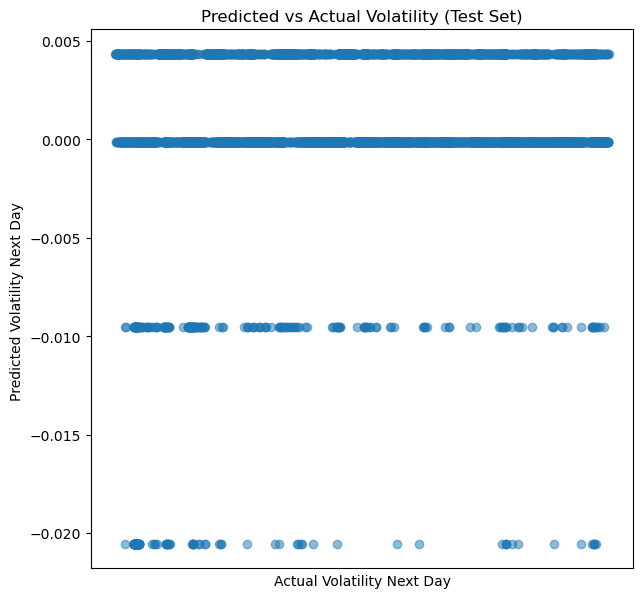

In [ ]:
# Plot predicted vs actual
y_test_plot = np.asarray(y_test)
plt.figure(figsize=(7, 7))
plt.scatter(y_test_plot, y_pred, alpha=0.5)
plt.xlabel('Actual Volatility Next Day')
plt.ylabel('Predicted Volatility Next Day ')
plt.title('Predicted vs Actual Volatility (Test Set)')
plt.xticks([])

plt.show()

In all, we have had little success attempting to model the actual volatility using the lagged actual volatility, SP500 lagged actual volatility and the lagged spike data using tree-based methods. 